# Live plots of Time Tagger measurements in a jupyter notebook

This jupyter notebook gives an example how to show live plots of Time Tagger Measurements. As an example, we enable the internal test signal and continuously plot the countrate.

### Idea

We use **plotly** for the plotting as it integrates nicely with the javascript side of jupyter and has better live plotting capabilities then matplotlib.

We use **asyncio** for background plot updates for its ease of use.

### Installation

Install __[anaconda python](https://www.anaconda.com/distribution/)__

Install jupyter, plotly, nodejs

```
conda install jupyter
conda install plotly
conda install nodejs
conda install ipywidgets
```

If you want to use jupyter lab, you may need to install jupyterlab extensions for plotly following the README on __[https://github.com/plotly/plotly.py](https://github.com/plotly/plotly.py)__


In [ ]:
from TimeTagger import *

import asyncio
import numpy as np
from ipywidgets import Button
import plotly.graph_objs as go

Connect to the TimeTagger and enable the internal test signal on channel 1

In [ ]:
# connect to the TimeTagger
tagger = createTimeTagger()

# enable the internal test signal on channels
tagger.setTestSignal(1, True)

Create a plot and mechanisms to update it in the background

In [ ]:
# create a counter with 100 ms binwidth and one bin
trace = Counter(tagger, [1], 10**9, 1000)

# create a figure widget and a plot
fig_trace = go.FigureWidget()
fig_trace.add_scatter(x=trace.getIndex(), y=trace.getData()[0])

async def update_trace():
    """Update the plot every 0.1 s"""
    while True:
        fig_trace.data[0].y = trace.getData()[0]
        await asyncio.sleep(0.1)

# If this cell is re-excecuted and there was a previous task, stop it first to avoid a dead daemon
try:
    task_trace.cancel()
except:
    pass
loop = asyncio.get_event_loop()
task_trace = loop.create_task(update_trace())
    
# create a stop button
button_trace = Button(description='stop')
button_trace.on_click(lambda a: task_trace.cancel())

display(fig_trace,button_trace)


You can stop the background plotting either by clicking on the stop button above or by executing `task_trace.cancel()`

In the next example we produce a bar plot by using a countrate with only one bin.

In [ ]:
# create a counter with 100 ms binwidth and one bin and 
point = Counter(tagger, [1], 10**11, 1)

# create a figure widget and a plot
fig_bar = go.FigureWidget()
fig_bar.add_bar(x=point.getIndex(), y=point.getData()[0])
fig_bar.layout.yaxis={'range':[0,100000]}

async def update_bar():
    """Update the plot every 0.1 s"""
    while True:
        fig_bar.data[0].y = point.getData()[0]
        await asyncio.sleep(0.1)

# If this cell is re-excecuted and there was a previous task, stop it first to avoid a dead daemon
try:
    task_bar.cancel()
except:
    pass
loop = asyncio.get_event_loop()
task_bar = loop.create_task(update_bar())

# create a stop button
button_bar = Button(description='stop')
button_bar.on_click(lambda a: task_bar.cancel())

display(fig_bar, button_bar)


Setting up the real time monitoring of ion number

c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

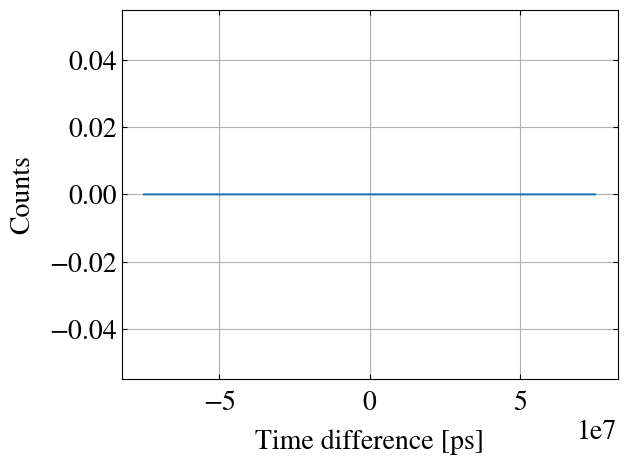

Date 2024-01-05, Time 15-59


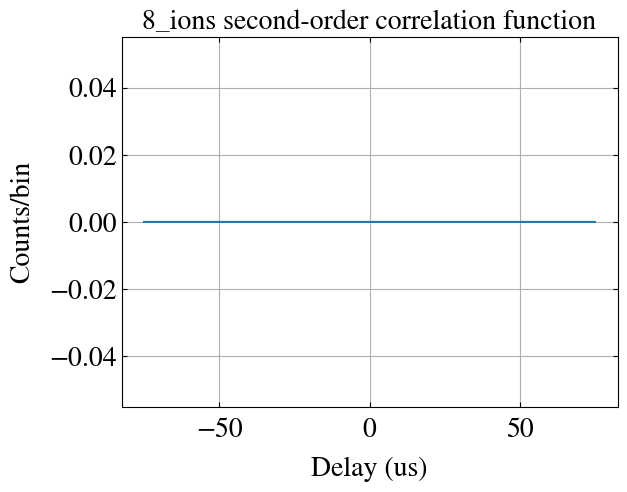

True

In [5]:
"""The Virtual Time Tagger is used to replay stored FileWriter files.
From the user perspective, there is no difference between the time tag stream of the physical Time
Tagger and the stream generated by the Virtual Time Tagger from a file. In this example, we first
store the data of a physical Correlation measurement using the FileWriter and SynchronizedMeasurements.
Later, we will be able to repeat the Correlation measurement based and to adjust the measurement
parameters."""

import os
from matplotlib import pyplot as plt
from datetime import datetime
import TimeTagger
import matplotlib
import asyncio
import numpy as np
from ipywidgets import Button
import plotly.graph_objs as go
import pprint
from matplotlib.animation import FuncAnimation

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 20,
         "xtick.direction": "in",
         "xtick.major.pad": 8,
         "xtick.top": True,
         "ytick.labelsize": 20,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 20,
         "axes.labelpad": 10,
         "axes.grid": True
    }
)

# Useful function for printing what is stored in the folder and display the files that are just created
def print_folder_content(folder):
    """Print filename and size of the files in the folder."""
    print("Filename            |       Size")
    print("--------------------+-----------")
    filenames = os.listdir(folder)
    for filename in [filenames[-1]] + filenames[:-1]:
        print("{:<20}|{:>8.1f} kB".format(filename, os.path.getsize(folder + os.sep + filename)/1024))

feature = "8_ions"

# Getting the current date and time
now = datetime.now()
# Extracting the date, hour, and minute
current_date = now.date()
current_hour = now.hour
current_minute = now.minute
# Converting to a char string
formatted_string = f"Date {current_date}, Time {current_hour}-{current_minute}"

# Specify the directory where you want to save the files and make sure the directory exists
save_directory = 'D:/Google_Drive/Simulation_Code/TimeTagger API examples/python/1-Quickstart/3-dump-and-reanalyze-time-tags'
os.makedirs(save_directory, exist_ok=True)
filename=save_directory + "/filewriter" + formatted_string + "_" + feature
# filename="D:/Google_Drive/Experimental_Data/Multiplexing/g2_data" + "/filewriterDate 2024-01-03, Time 13-49.1"

# Create a TimeTagger instance to control your hardware
tagger = TimeTagger.createTimeTagger()

# # Start of the first round with SynchronizedMeasurements
# print("\nThe first round uses the FileWriter with SynchronizedMeasurements.")
# input("-> Press Enter to run")

# We synchronize the FileWriter to our Correlation measurement to run the
# repeated measurements on the very same set of time tags as the original one.
synchronized = TimeTagger.SynchronizedMeasurements(tagger=tagger)
Counter = TimeTagger.Counter(tagger=tagger, channels=[1, 3], binwidth=int(300 * 1e9), n_values=100)
filewriter = TimeTagger.FileWriter(tagger=synchronized.getTagger(),
                                   filename=filename,
                                   channels=[1, 2, 3])
# synchronized.startFor(int(0.3 * 3600 * 1e12))
# synchronized.waitUntilFinished()

# # We let the measurements run for 18 mins and watch the data accumulation
# fig = plt.figure()
# synchronized.startFor(int(0.01 * 3600 * 1e12))
# while synchronized.isRunning():
#     fig.clear()
#     plt.plot(Counter.getDataNormalized())
#     plt.xlabel("Time bins")
#     plt.ylabel("Counts")
#     plt.show()
#     # plt.pause(.1)

# Initialize lists to store PMT data
data_pmt1 = []
data_pmt2 = []

def update(frame):
    data = Counter.getDataNormalized()
    # Check if data is not None and has at least two elements
    if data is not None and len(data) >= 2:
        # Append new data points from PMTs
        data_pmt1.append(data[0])
        data_pmt2.append(data[1])
    
    # Clear the current plot completely
    plt.clf()

    # Re-plot the data for both PMTs with consistent colors
    plt.plot(data_pmt1, label='PMT1 Counts', color='blue')
    plt.plot(data_pmt2, label='PMT2 Counts', color='green')

    # Set labels and legend
    plt.xlabel("Time bins")
    plt.ylabel("Counts")
    plt.legend()
    plt.draw()

# Create a figure
fig = plt.figure()

# Start the measurements
synchronized.startFor(int(0.01 * 3600 * 1e12))  # Uncomment this if required

# Create an animation that updates the plot every 100 milliseconds
ani = FuncAnimation(fig, update, interval=100, cache_frame_data=False)

# Display the plot
plt.show()

# Now the data acquisition is done and we can release the measurements
del synchronized
del Counter
del filewriter
TimeTagger.freeTimeTagger(tagger)
del tagger

# The Virtual Time Tagger is initialized similar to the physical one
tagger = TimeTagger.createTimeTaggerVirtual()
fig = plt.figure()

# The while loop allows us to repeat the replay several times
i = 1
while i == 1:
    i += 1
    # print("\nInput data for the data replay")

    # # The request_values function allows us to input our data
    # corr_param, replay_speed, replay_begin, replay_duration = request_values()
    trigger_channel = 2
    PMT_channel1 = 1
    PMT_channel2 = 3
    binwidth = 50 * 1e3  # Adjust binwidth as needed
    n_bins = 3000   # Adjust number of bins as needed
    # DELAY = 200 * 1e3 # The gate time is 1us

    open_gate = TimeTagger.DelayedChannel(tagger=tagger, input_channel=trigger_channel, delay=2000 * 1e3)
    open_gate_channel = open_gate.getChannel()
    close_gate = TimeTagger.DelayedChannel(tagger=tagger, input_channel=open_gate_channel, delay=200 * 1e3)
    close_gate_channel = close_gate.getChannel()

    gated_PMT_channel1 = TimeTagger.GatedChannel(tagger=tagger, input_channel=PMT_channel1, gate_start_channel=open_gate_channel, gate_stop_channel=close_gate_channel)
    gated_PMT_channel2 = TimeTagger.GatedChannel(tagger=tagger, input_channel=PMT_channel2, gate_start_channel=open_gate_channel, gate_stop_channel=close_gate_channel)

    # Start the correlation measurement
    # We can pass virtual_tagger to the "tagger" argument of any measurement class constructor
    corr = TimeTagger.Correlation(tagger=tagger, channel_1=gated_PMT_channel1.getChannel(), channel_2=gated_PMT_channel2.getChannel(), binwidth=binwidth, n_bins=n_bins)
    # measurement_time = int(0.001 * 3600 * 1e12)  # Adjust measurement time as needed

    # In general, the data are replayed at the same speed as they have been acquired.
    # You can modify the speed by a factor or replay them as fast es possible by speed < 0
    tagger.setReplaySpeed(speed=-1)

    # Start the replay
    tagger.replay(file=filename)

    while not tagger.waitForCompletion(timeout=0):
        fig.clear()
        plt.plot(corr.getIndex(), corr.getData())
        plt.xlabel("Time difference [ps]")
        plt.ylabel("Counts")
        plt.show()
        plt.pause(.1)

    # Get the correlation data
    g2_data = corr.getData()
    index = corr.getIndex() / 1e6

    # Converting to a char string
    formatted_string = f"Date {current_date}, Time {current_hour}-{current_minute}"
    print(formatted_string)

    np.save('corr_meas_'+feature+formatted_string+'.npy', index, g2_data)

    # Plot the g(2) function
    plt.plot(index, g2_data)
    plt.title(feature+" second-order correlation function", fontdict={'size':20})
    plt.xlabel("Delay (us)")
    plt.ylabel("Counts/bin")
    plt.show()

    # Getting the current date and time
    now = datetime.now()

    # Extracting the date, hour, and minute
    current_date = now.date()
    current_hour = now.hour
    current_minute = now.minute

    np.save('corr.getData_'+feature+formatted_string+'.npy', corr.getData())
    np.save('corr.getIndex_'+feature+formatted_string+'.npy', corr.getIndex())

# Free the TimeTagger
TimeTagger.freeTimeTagger(tagger)